In [7]:
# Written by Kalon Overholt
# Young Lab
# 3/9/2022
# This script calculates binding isotherms obtained with fluorescent polarization data for equilibrium protein-ligand interactions using a ligand depletion model

In [38]:
# Import libraries
import scipy as sp
from pylab import *
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from IPython.display import clear_output
import random
sns.set_style("ticks")
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

import matplotlib as mpl
mpl.use('Agg')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['figure.dpi'] = 300
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
# Define parameters
L=10 # Ligand (RNA) concentration (nM)

In [10]:
# Create function handle
def modelfun(x,b0,b1,b2):
    return b1+(b2-b1)*(L+x+b0-np.sqrt((L+x+b0)**2-4*L*x))/(2*L)

In [54]:
# From https://kitchingroup.cheme.cmu.edu/blog/2013/02/18/Nonlinear-curve-fitting-with-confidence-intervals/
def nl_95_ci(pars, pcov,Y):
    alpha = 0.05 # 95% confidence interval

    n = len(Y)    # number of data points
    p = len(pars) # number of parameters

    dof = max(0, n-p) # number of degrees of freedom

    tval = t.ppf(1.0 - alpha / 2.0, dof) # student-t value for the dof and confidence level

    for i, p,var in zip(range(n), pars, np.diag(pcov)):
        sigma = var**0.5
        lb=p - sigma*tval
        ub=p + sigma*tval
        
        if i==0:
            ci_kd=[lb,ub]
            
    return ci_kd

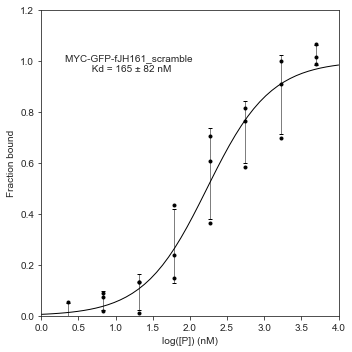

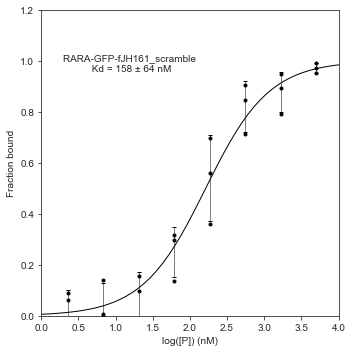

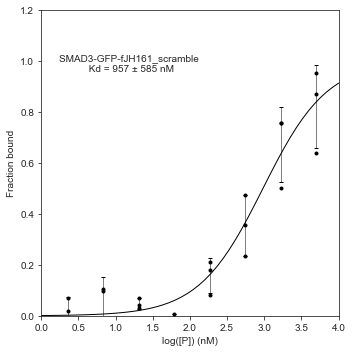

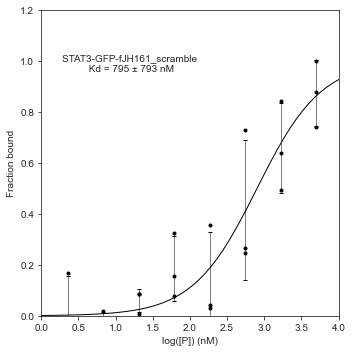

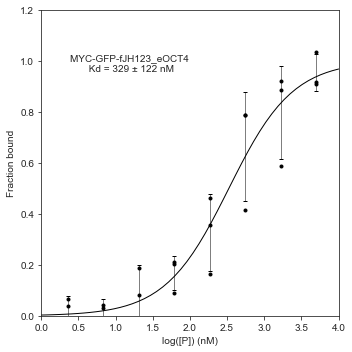

<ipython-input-10-2e34af230ad4>:3: RuntimeWarning: invalid value encountered in sqrt
  return b1+(b2-b1)*(L+x+b0-np.sqrt((L+x+b0)**2-4*L*x))/(2*L)


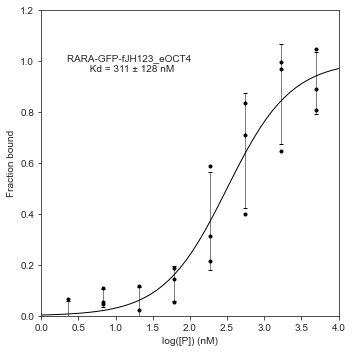

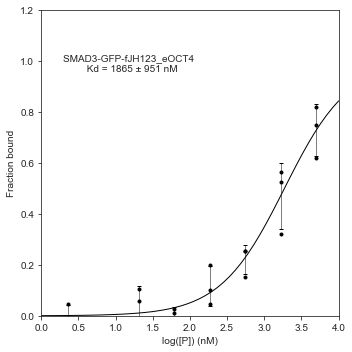

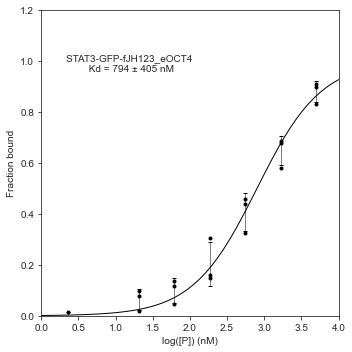

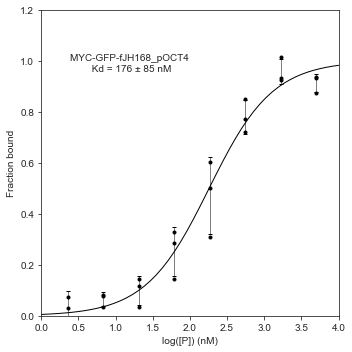

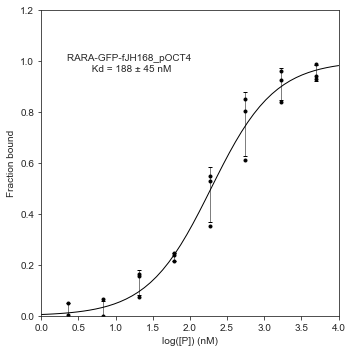

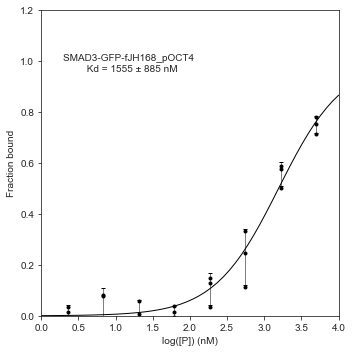

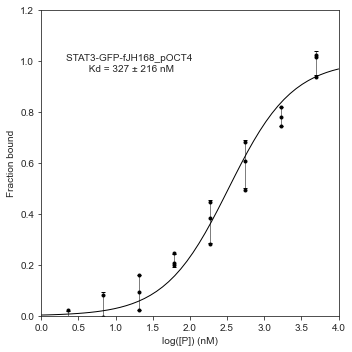

In [55]:
# Read in data
filename='220111_TF_diverseRNA-analysis';
T=pd.read_csv(filename+'.csv',header=None,index_col=0)
proteins=pd.unique(T.index)

nrows=size(T,0)

i=0;
j=0;
k=3; # Number of replicates
n=len(proteins);

save = False # Whether to save the plots

while i<nrows:

    P=T.iloc[i,:]
    P=P.to_numpy()
    data=T.iloc[i+1:i+1+k,:]
    Y=np.mean(data,axis=0)
    
    # Fit model for fraction ligand bound
    # Modeled by anisotropy when ligand is fluorescent

    p0=[1000, 200, 400] #Define intial guess for the fit parameter for Kd
    popt, pcov = curve_fit(modelfun,P,Y,p0)
    b0=popt[0]
    b1=popt[1]
    b2=popt[2]
    kd=round(b0)
    
    # Calculate confidence intervals
    ci_kd=nl_95_ci(popt, pcov,Y)
    pm=round(ci_kd[1]-kd)
    
    i=i+k+1; # Skip to the next protein
    
    p_sim = np.logspace(0,4)
    
    anisotropy=modelfun(p_sim,b0,b1,b2)    
    fb=(anisotropy-b1)/(b2-b1);
    data_fb=(data-b1)/(b2-b1);
    Y_fb=(Y-b1)/(b2-b1);

    # Plot fraction bound isotherms
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    
    ax.plot(np.log10(p_sim),fb,'-',color='k',linewidth=1) # Plot fit curve
    ax.plot(np.log10(P),data_fb.T, marker='.', color='k', linewidth=0) # Plot data points
    ax.errorbar(np.log10(P),Y_fb,np.std(data_fb,ddof=1),ecolor='black',elinewidth=0.5,capsize=2,ls='none') # Plot error bars with ddof=1 for sample standard deviation

    # With this away of putting in the text, the size of the plot doesn't change because of the title
    ax.text(0.3, 0.8, f'{proteins[j]} \n Kd = {str(kd)} \u00B1 {str(pm)} nM', horizontalalignment='center', transform=ax.transAxes) # text is placed according to axes coordinates

    ax.set_xlim([0, 4])
    ax.set_ylim([0, 1.2])

    ax.set_xlabel('log([P]) (nM)')
    ax.set_ylabel('Fraction bound')

    fig.tight_layout()

    if save:
        pass
        plt.savefig(filename+proteins[j]+'.pdf',bbox_inches='tight')
        plt.close()
    else:
        plt.show()

    
    # Plotting anisotropy
#         plotHandles(j)=plot(log10(p_sim),anisotropy,'-','Color',color);
#         hold on
#         plot(log10(P),data,'.','Color',color);
#         errorbar(log10(P), Y, std(data), 'LineStyle','none','Color',color);
#         xlabel('log([P]) (nM)','FontSize',14)
#         ylabel('Anisotropy','FontSize',14)
#         xlim([0 4])
#         ylim([100 300])
      
    j=j+1;